In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy

In [2]:
# constants
v_0 = -1.0
R = 6.0
M = 1000

x = np.linspace(-R, R, M+1)
delta = x[1] - x[0]

# matrices
diag_T = 2/delta**2
subdiag_T = -1/delta**2 * np.ones(M-2)

diag_V = v_0*np.exp(-x[1:-1]**2)

diags_T = [subdiag_T, diag_T, subdiag_T]
T = scipy.sparse.diags(diags_T,[-1,0,1]).toarray()

diags_V = [diag_V]
V = scipy.sparse.diags(diags_V,[0]).toarray()

# Ground state

In [3]:
R = lambda z : scipy.linalg.inv(T - z * scipy.sparse.eye(M-1).toarray())
L = lambda z : - R(z) @ V

def lambda_0(z):
    L_ = L(z)
    
    lambda_z = 0.0
    phi_1 = np.exp(-x[1:-1]**2) / scipy.linalg.norm(np.exp(-x[1:-1]**2))
    
    while scipy.linalg.norm(L_ @ phi_1 - lambda_z * phi_1) > 1e-4:
        phi_2 = L_ @ phi_1
    
        phi_1 = phi_2 / scipy.linalg.norm(phi_2)
    
        lambda_z = np.dot(phi_2, phi_1)
    
    return lambda_z

In [4]:
z = np.linspace(v_0,0.0,100)
lambda_0_ = np.full(len(z), np.nan)

for i in range(len(z)):
    if i % 10 == 0:
        print(i)
    lambda_0_[i] = lambda_0(z[i])

0
10
20
30
40
50
60
70
80
90


In [5]:
lambda_0_cs = scipy.interpolate.CubicSpline(z, lambda_0_)

sol = scipy.optimize.root_scalar(lambda x: lambda_0_cs(x) - 1.0, bracket=[v_0, 0.0], method='brentq')
sol.root

-0.3525682174889015

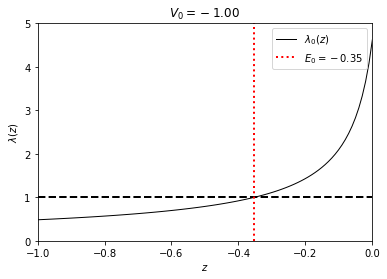

In [6]:
plt.plot(z, lambda_0_, color='black', linewidth=1, label=r'$\lambda_0(z)$')
plt.axhline(y=1, linestyle='--', color='black', linewidth=2)
plt.axvline(x=sol.root, linewidth=2, linestyle=':', color='red', label=fr'$E_0 = {sol.root:>0.2f}$')

plt.legend()
plt.xlim(v_0,0.0)
plt.ylim(0.0,5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\lambda(z)$')
plt.title(fr'$V_0 = {v_0:>0.2f}$')

plt.savefig(f'figures/{v_0}_l0.png', dpi=250)

# Other states too

In [7]:
def arnoldi_iteration(A, b, n: int):
    """Computes a basis of the (n + 1)-Krylov subspace of A: the space
    spanned by {b, Ab, ..., A^n b}.

    Arguments
      A: m × m array
      b: initial vector (length m)
      n: dimension of Krylov subspace, must be >= 1
    
    Returns
      Q: m x (n + 1) array, the columns are an orthonormal basis of the
        Krylov subspace.
      h: (n + 1) x n array, A on basis Q. It is upper Hessenberg.  
    """
    eps = 1e-12
    h = np.zeros((n+1,n))
    Q = np.zeros((A.shape[0],n+1))
     # Normalize the input vector
    Q[:,0] =b/np.linalg.norm(b,2)   # Use it as the first Krylov vector
    for k in range(1,n+1):
        v = np.dot(A,Q[:,k-1])  # Generate a new candidate vector
        for j in range(k):  # Subtract the projections on previous vectors
            h[j,k-1] = np.dot(Q[:,j].T, v)
            v = v - h[j,k-1] * Q[:,j]
        h[k,k-1] = np.linalg.norm(v,2)
        if h[k,k-1] > eps:  # Add the produced vector to the list, unless
            Q[:,k] = v/h[k,k-1]
        else:  # If that happens, stop iterating.
            return Q, h
    return Q, h

def lambda_z(z,n):
    Q, h = arnoldi_iteration(L(z), np.random.rand(len(x[1:-1])), n=n)
    return np.real(scipy.linalg.eigvals(h[:-1]))

In [8]:
n = 200 # how many branches of lambda with wich we want to deal 

z = np.linspace(v_0,0.0,100)
lambda_ = np.full((n, len(z)), np.nan)

for i in range(len(z)):
    if i % 10 == 0:
        print(i)
    lambda_[:,i] = lambda_z(z[i],n)

0
10
20
30
40
50
60
70
80
90


0 -0.3525628107808904


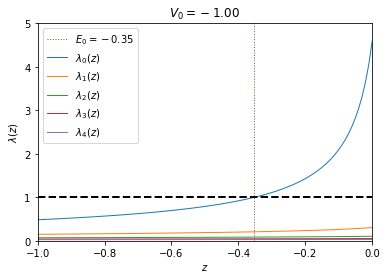

In [9]:
for i in range(5):
    lambda_cs = scipy.interpolate.CubicSpline(z, lambda_[i])
    
    if (lambda_cs(v_0)<1) and (lambda_cs(0.0)>1):
        sol = scipy.optimize.root_scalar(lambda x: lambda_cs(x) - 1.0, bracket=[v_0, 0.0], method='brentq')
        print(i, sol.root)
        plt.axvline(x=sol.root, linewidth=1, color=f'C{i+5}', linestyle=':', label=fr'$E_{i} = {sol.root:>0.2f}$')
    
    plt.plot(z, lambda_[i], linewidth=1, label=fr'$\lambda_{i}(z)$')
    
    
plt.axhline(y=1, linestyle='--', color='black', linewidth=2)


plt.legend()
plt.xlim(v_0,0.0)
plt.ylim(0.0,5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\lambda(z)$')
plt.title(fr'$V_0 = {v_0:>0.2f}$')

plt.savefig(f'figures/{v_0}_l{5}.png', dpi=250)